In [22]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl
%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log
from pandas import DataFrame

import seaborn as sns 
import statsmodels.api as sm
import statsmodels.stats.api as sms

EarLobe = pd.read_csv('datensatz/earLobe.csv')
InnerArm = pd.read_csv('datensatz/innerArm.csv')
Vein = pd.read_csv('datensatz/vein.csv')
ThumbNail = pd.read_csv('datensatz/thumbNail.csv')


In [37]:
## THUMBNAIL 
ThumbNail = open('datensatz/thumbNail.csv', 'r') 
ThumbNail_Data = ThumbNail.readlines()
ThumbNail_inputs = np.empty([21,3159])

k=0
for i in range(1, len(ThumbNail_Data)):
    ThumbNail_line = ThumbNail_Data[i].split(',')
    ThumbNail_input = np.asfarray(ThumbNail_line[3:])

    ThumbNail_inputs[k] = ThumbNail_input
    k+=1
    pass


## VEINS 
Vein = open('datensatz/vein.csv', 'r') 
Vein_Data = Vein.readlines()
Vein_inputs = np.empty([21,3159])

k=0
for i in range(1, len(Vein_Data)):
    Vein_line = Vein_Data[i].split(',')
    Vein_input = np.asfarray(Vein_line[3:])

    Vein_inputs[k] = Vein_input
    k+=1
    pass


## EARLOBE 
EarLobe = open('datensatz/earLobe.csv', 'r') 
EarLobe_Data = EarLobe.readlines()
EarLobe_inputs = np.empty([21,3159])

k=0
for i in range(1, len(EarLobe_Data)):
    EarLobe_line = EarLobe_Data[i].split(',')
    EarLobe_input = np.asfarray(EarLobe_line[3:])

    EarLobe_inputs[k] = EarLobe_input
    k+=1
    pass

## INNERARM
InnerArm = open('datensatz/innerArm.csv', 'r') 
InnerArm_Data = InnerArm.readlines()
InnerArm_inputs = np.empty([21,3159])

k=0
for i in range(1, len(InnerArm_Data)):
    InnerArm_line = InnerArm_Data[i].split(',')
    InnerArm_input = np.asfarray(InnerArm_line[3:])

    InnerArm_inputs[k] = InnerArm_input
    k+=1
    pass


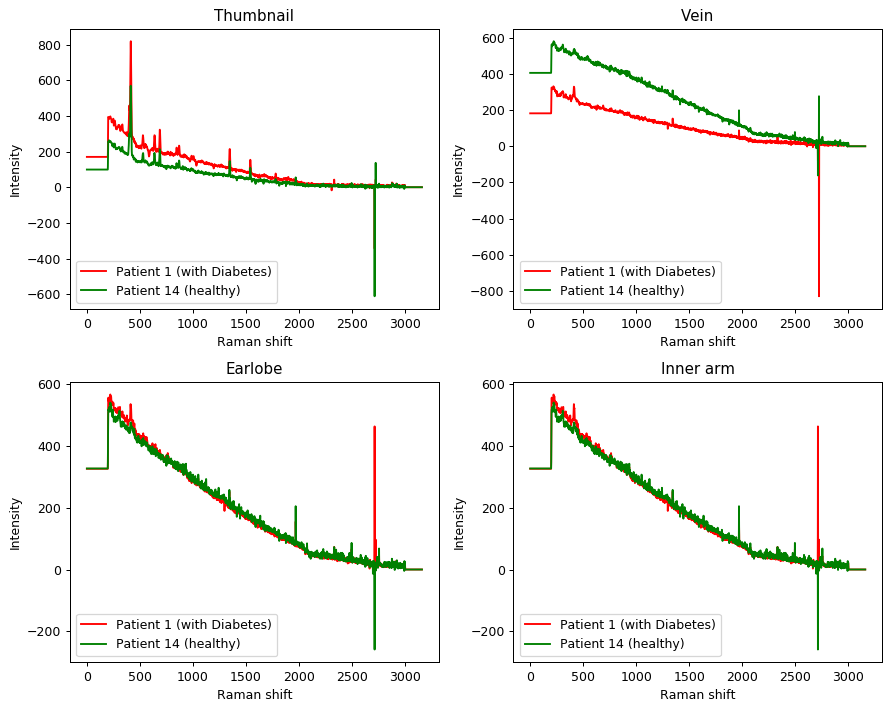

In [47]:
# Plot für Patient 1,2 (transponiert)

plt.figure(figsize=(10, 8), dpi=90)

plt.subplot(221);  

plt.plot(ThumbNail_inputs[1].T, 'r', label="Patient 1 (with Diabetes)")
plt.plot(ThumbNail_inputs[14].T, 'g', label="Patient 14 (healthy)")
plt.title('Thumbnail');
plt.legend(loc='lower left');
plt.xlabel('Raman shift');
plt.ylabel('Intensity'); 

plt.subplot(222);  
plt.plot(Vein_inputs[1].T, 'r', label="Patient 1 (with Diabetes)")
plt.plot(Vein_inputs[14].T, 'g', label="Patient 14 (healthy)")
plt.title('Vein');
plt.legend(loc='lower left');
plt.xlabel('Raman shift');
plt.ylabel('Intensity'); 

plt.subplot(223);  
plt.plot(EarLobe_inputs[1].T, 'r', label="Patient 1 (with Diabetes)")
plt.plot(EarLobe_inputs[14].T, 'g', label="Patient 14 (healthy)")
plt.title('Earlobe');
plt.legend(loc='lower left');
plt.xlabel('Raman shift');
plt.ylabel('Intensity'); 

plt.subplot(224);  
plt.plot(InnerArm_inputs[1].T, 'r', label="Patient 1 (with Diabetes)")
plt.plot(InnerArm_inputs[14].T, 'g', label="Patient 14 (healthy)")
plt.title('Inner arm');
plt.legend(loc='lower left');
plt.xlabel('Raman shift');
plt.ylabel('Intensity');

plt.tight_layout();

In [44]:
# Inner Arm und Earlob sind identisch ?! 
# Frage: 
    # Was ist mit Klassen gemeint? 
    # graphische Darstellung so in Ordnung oder noch mehr? Korrelationsmatrix, etc? 


566.4323883

566.4323883